<a href="https://colab.research.google.com/github/judysitero/judysitero/blob/main/Topic_Modeling_(414).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)


![](https://drive.google.com/uc?export=view&id=1Aze8Xe_ZZpV22IwFNUH09T2howHmF1AK)

[Image Credit: slides from Ben Mabey](https://speakerdeck.com/bmabey/visualizing-topic-models)

In Module 1, we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are often not explicitly called out and labeled in the document corpus. So some extra work is needed to figure out the topics. Today we will learn a powerful technique for doing this (almost) automatically!

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: What the are your documents about? <br>
What are some industrial applications?
* Identifying common themes in customer reviews
* Grouping job ads into categories 
* Sorting customer inquiries into categories so they can be routed to the appropriate department for processing.
* Monitoring communications (Email - State Department, Google) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 1: Describe how a Latent Dirichlet Allocation (LDA) Model works
* Part 2: Build a LDA Model with Gensim
* Part 3: Interpret LDA results & Select an appropriate number of topics

##1.0 Setup

##1.0.1 Get spacy

In [ ]:
# could use *web_lg or *web_sm instead
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96.4 MB 1.2 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=0b71fbc312b810b9ab488ea33615912bf443b0f36cd9741a71d3474d26b2f94e
  Stored in directory: /tmp/pip-ephem-wheel-cache-98sa4b0r/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


## 1.0.1 Restart runtime!
On Colab, we need to restart runtime after this step, <br>
or else Colab won't find spacy!

##1.0.2 Install dependencies

In [ ]:
# Dependencies for the week (instead of conda)
# Run if you're using colab, otherwise you should have a local copy of the data
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
!pip install -r requirements.txt

--2022-06-20 22:03:33--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149 [text/plain]
Saving to: ‘requirements.txt.2’

requirements.txt.2  100%[===================>]     149  --.-KB/s    in 0s      

2022-06-20 22:03:33 (7.44 MB/s) - ‘requirements.txt.2’ saved [149/149]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##1.0.3 Imports and such

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.datasets import fetch_20newsgroups
from pandarallel import pandarallel

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:169: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=n

# Part 1: Building a Latent Dirichlet Allocation (LDA) Topic Model with Gensim

Our goal in this module is to get hands-on experience in how to build and train a Latent Dirichlet Allocation topic model using the **Gensim** library. 

## 1.1 Latent Dirichlet Allocation (LDA) 
is a more sophisticated method of topic modelling than Latent Semantic Indexing (LSI) which we used in Module 2. Because of its complexity, a full discussion of the machinery of LDA is beyond the scope of Unit 4. We'll focus on a high level of understanding of Latent Dirichlet Allocation, meaning we'll emphasize "what it does" rather than "how it does it". 

LDA takes as input the corpora of documents and the number of topics that you want to identify. LDA models topics as probability distributions over words, and it models documents as probability distributions over topics.

LDA is a generative probabilistic model. That means it can generate documents from probability distributions. Given an article length (number of words), an assumed probability distribution of topics, and an assumed distribution of words for each topic, LDA can generate an article, in the form of a bag of words. LDA works by starting with random distributions of words over topics and  topics over documents, then iteratively adjust these probability distributions until the generated documents are similar in structure to the input documents.





### 1.1.1 Resources for LDA

[**Your Guide to Latent Dirichlet Allocation**](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d) is a highly recommended Medium article that works through an example of LDA in elementary terms

[**LDA Topic Modeling**](https://lettier.com/projects/lda-topic-modeling/) is an interactive data visualization tool -- created by the author of the above article -- that allows us to explore a simple and visual example of LDA.

[**Topic Modeling with Gensim**](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) disccusses an example implementing LDA using the same dataset that we are using in this guided project.  

Luis Serrano's video [**Latent Dirichlet Allocation**](https://youtu.be/T05t-SqKArY) does a great job of breaking down and explaining LDA in an understandable way.



### 1.1.2 Further discussion of LDA (Optional)

LDA is a [**Probabilistic Graphical Model (PGM)**](https://en.wikipedia.org/wiki/Graphical_model)

A PGM can be represented by a graph that expresses the conditional dependence structure between random variables. Here's a graphical representation of the LDA model: 

![](https://filebox.ece.vt.edu/~s14ece6504/projects/alfadda_topic/main_figure_3.png)

The image shows the hierarchical dependency between probability distributions and their parameters. This is an application of Hierarchical Bayesian Modeling. 

In order to understand how LDA works, one must first understand how PGMs work, which is beyond the scope of Unit 4. If this is something that you're interested in learning more about, here are some resources: 

This Github repo that has transformed a textbook in a collection of Jupyter Notebooks. This repo is called [**"Bayesian Methods for Hackers"**](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) <br>
The cool thing about this repo is that each chapter covers the same material using four popular python probabilistic modeling libraries: **PyMC2, PyMC3, Pyro, and Tensorflow Probability.** So you can choose your preferred library.

[**Pyro**](https://pyro.ai/) is considered a very powerful probabilistic programming library that even combines probabilistic programming with deep learning. 

## 1.2 Preparing our text data set for LDA topic modeling with `gensim`
For this guided project we'll work with the `20newsgroups` data set that is  familiar from Module 3, but we'll extract articles from a different set of categories.<br><br>
`gensim` is a Natural Language Processing Library, specialized for Topic Modeling applications. The two main inputs required for a `gensim` LDA topic model are the dictionary (`id2word`) and the `corpus`.<br><br>
`id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text <br><br>
The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`.<br>

In this section, we will first download and clean the raw text documents, then use `spacy` to tokenize and lemmatize them. Then we'll use `gensim` to create the `id2word` and `corpus` objects that we need for topic modeling with `gensim`<br>

In Part 2, we'll build and train the LDA topic model in `gensim`.

References: 
- [Gensim Tutorial – A Complete Beginners Guide](https://www.machinelearningplus.com/nlp/gensim-tutorial/)
- [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

# Problem Statement



We'll extract articles belonging to the following four topics (as assigned in the 20newsgroups database)

    sci
        \_ electronics, space


    talk
        \_politics 
                  \_ guns, middle east
              
What's the best way to categorize these emails - is it between science and talk? 

Or it between electronics, space, guns, and the Middle East? 

The Middle East is a pretty broad topic in and of itself, should that topic be broken down into further sub-topics?

Let's learn about Topic Modeling and how it can help us answer these questions!

### Load Email Corpus


In [ ]:
# notice that the categories are hierarchical
# so there is a sense in which we have 2 topics, but also as many as 4 topics  
categories = ['sci.electronics', 'sci.space', 
              'talk.politics.guns', 'talk.politics.mideast']
data = fetch_20newsgroups(subset='all', 
                          remove=('headers', 'footers', 'quotes'),
                          random_state=42, shuffle=True,
                          categories=categories)

In [ ]:
dir(data)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [ ]:
#This will be our x
data['data']

In [ ]:
data['target_names']

['sci.electronics', 'sci.space', 'talk.politics.guns', 'talk.politics.mideast']

In [ ]:
#This will be our target "y"
data['target']

array([2, 2, 1, ..., 2, 0, 0])

In [ ]:
# create X and y from data, as we did in the Module 3 Lecture notebook

###BEGIN SOLUTION
X = data.data
y = data.target
target_names = data.target_names
###END SOLUTION

In [ ]:
target_names

['sci.electronics', 'sci.space', 'talk.politics.guns', 'talk.politics.mideast']

What are the possible targets (labels)

In [ ]:
np.unique(y)

array([0, 1, 2, 3])

What are the newsgroup names that correspond to the labels?

In [ ]:
target_names

['sci.electronics', 'sci.space', 'talk.politics.guns', 'talk.politics.mideast']

Create a data frame with columns for the documents, the newsgroup names, and their numerical labels.

In [ ]:
data_dict = {
    'content': X,
    'target': y,
    'target_names': [target_names[target_index] for target_index in y]
}

df = pd.DataFrame(data=data_dict)

In [ ]:
df.head()

,content,target,target_names
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns
2,==========================\n ...,1,sci.space
3,"From: ""Phil G. Fraering"" <pgf@srl03.cacs.usl.e...",1,sci.space
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns


In [ ]:
len(df)

3821

Re-use our `clean_data()` helper function from Module 3.

In [ ]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document. 
    
    Parameters
    ----------
    text: string or object 
    
    Returns
    -------
    text: string or object
    """
    
    # order of operations - apply the expression from top to bottom
    # email_regex = "@\S*\S*\s?"
    # non_alpha = '[^a-zA-Z]'  #this would remove numbers
    # multi_white_spaces = "[ ]{2,}"
    
    # text = re.sub(email_regex, "", text)
    # text = re.sub(non_alpha, ' ', text)
    # text = re.sub(multi_white_spaces, " ", text)

#THIS IS THE VERSION THAT WE LIKE
    text = re.sub('\S+@\S+.\S+', 'EMAIL', text)
    #text = re.sub('[^a-zA-Z0-9 ]', ' ', text)
    text = re.sub('[ ]{2,}', ' ', text)
    
    # apply case normalization 
    return text.lower().strip()

Clean the text string data and save it in a new column

In [ ]:
df["clean_data"] = df["content"].apply(clean_data)

In [ ]:
df.head()

,content,target,target_names,clean_data
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns,[...]\n\nsome of the davidians *are* black.\n\...
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns,"how about ""firearm related.""\n\n\n texas is un..."
2,==========================\n ...,1,sci.space,==========================\n ozone gif images\...
3,"From: ""Phil G. Fraering"" <pgf@srl03.cacs.usl.e...",1,sci.space,"from: ""phil g. fraering"" email\n >> finally: t..."
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns,from article email email r. stone):\n\ni secon...


In [ ]:
df['clean_data'][1]

'how about "firearm related."\n\n\n texas is unusual in this regard. it would be nice to reduce them\nboth, though.\n\n as texas doesn\'t appear to have an murder rate that much higher than\nthe national average, i would expect it is a result of a much higher\nsuicide rate.\n\n\n be nice if you didn\'t have to suffer at all.\n\n\n here\'s where we run into a problem. i am perfectly willing to\nhave government regulation on something which is likely to cause others\nharm. what we\'re discussing, though, is the extreme regulation of a large\ngroup in order to target a small group, and i don\'t think that\'s\nappropriate. \n\n\n does this, then, justify anything? at some point you have to draw\na line (at least to my way of thinking) where the government must have\nsomething a little more substantial than a set of percentages with which\nto punish an individual.\n\n where do *you* draw the line? or is there one?\n\n\n virginia. it passed.\n\n\n does it?\n\n\n cute analogy. \n\n the u.s. d

### Create Tokens 

Before we can use the `gensim` library to create bag-of-words vectors in exactly the right way that the LDA model wants, we must first create tokens. 

Let's use spaCy to create some lemmas. But first let's initialize our multi-processing library `pandarallel` which will empower us to use the same dataframe that our data is stored in but be able to create tokens in parallel so as to save time.

Here's the documentation for [**pandarallel**](https://github.com/nalepae/pandarallel)

In [ ]:
# we must initalize pandarallel before we can use it
pandarallel.initialize(progress_bar=True, nb_workers=2)
# so that the progress bars will work
from pandarallel.utils import progress_bars
progress_bars.is_notebook_lab = lambda : True

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


ImportError: ignored

In [ ]:
# load in our spaCy language model
nlp = spacy.load("en_core_web_md")

In [ ]:
%%time
# create our tokens in the form of lemmas 

# parallel_apply takes about 2 min on Colab
#df['lemmas'] = df['clean_data'].parallel_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

# parallel_map takes about 50 sec
df['lemmas'] = df['clean_data'].map(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True) and (token.is_space != True)])


CPU times: user 2min 39s, sys: 2.4 s, total: 2min 41s
Wall time: 2min 50s


### Take a look at our lemmas

In [ ]:
df['lemmas'][1]

['firearm',
 'relate',
 'texas',
 'unusual',
 'regard',
 'nice',
 'reduce',
 'texas',
 'appear',
 'murder',
 'rate',
 'high',
 'national',
 'average',
 'expect',
 'result',
 'high',
 'suicide',
 'rate',
 'nice',
 'suffer',
 'run',
 'problem',
 'perfectly',
 'willing',
 'government',
 'regulation',
 'likely',
 'cause',
 'harm',
 'discuss',
 'extreme',
 'regulation',
 'large',
 'group',
 'order',
 'target',
 'small',
 'group',
 'think',
 'appropriate',
 'justify',
 'point',
 'draw',
 'line',
 'way',
 'thinking',
 'government',
 'little',
 'substantial',
 'set',
 'percentage',
 'punish',
 'individual',
 'draw',
 'line',
 'virginia',
 'pass',
 'cute',
 'analogy',
 'u.s',
 'treat',
 'drunk',
 'driving',
 'like',
 'crime',
 'confiscate',
 'car',
 'people',
 'drink',
 'confiscate',
 'car',
 'people',
 'drink',
 'drive',
 'core',
 'legal',
 'system',
 'order',
 'punish',
 'individual',
 'property',
 'confiscation',
 'punishment',
 'evidence',
 'individual',
 'majority',
 'people',
 'convict',


In [ ]:
print(df['lemmas'][3])

['phil', 'g.', 'fraering', 'email', '>', '>', 'finally', 'bronze', 'age', '>', '>', 'try', 'remember', 'human', 'activity', '>', '>', 'practice', 'warrior', 'caste', 'farming', 'caste', '>', '>', 'priesthood', 'f', 'baube', 'respond', 'right', 'profit', 'caste', 'bless', 'god', 'freely', 'blare', 'presence', 'evening', 'twilight', 'steinn', 'sez', '>', 'priesthood', 'forgive', '>', 'merchant', 'aka', 'profit', 'caste', 'sic', '>', 'rise', 'power', 'look', 'evidence', 'belesse', 'god', 'ness', 'ability', 'blare', 'light', 'evening', 'sky', 'good', 'evidence', 'hope', 'wonder', 'preistly', 'class', 'upset', '-tommy', 'mac', 'tom', 'mcwilliams', '517', '355', '2178', 'wk', 'radius', 'vision', 'increase', 'email', 'hm', 'circumference', 'mystery', 'grow']


In [ ]:
# print out the lemmas from the first article
# note that some lemmas are only 1 character: you could modify the code above to not include lemmas that are only 1 or 2 characters
print(df['lemmas'][5])

['gene', 'wright', 'email', 'imagine', 'couple', 'group', 'maybe', 'land', 'week', 'apart', 'year', 'mark', 'start', 'come', 'group', 'billion', 'pretty', 'good', 'incentive', 'shot', 'potential', 'winner', 'yeah', 'shame', 'team', 'life', 'support', 'give', 'close', 'deadline', 'thank', 'billion', 'hand', 'apollo', 'cost', '~25billion', 'day', 'week', 'space', '1970', 'dollar', 'will', 'reward', 'lot', '1', 'billion', 'taker', '-tommy', 'mac', 'tom', 'mcwilliams', '517', '355', '2178', 'wk', 'radius', 'vision', 'increase', 'email', 'hm', 'circumference', 'mystery', 'grow']


### Filter out low quality lemmas
1 or 2 characters

In [ ]:
def filter_lemmas(lemmas):
    """
    Filter out any lemmas that are 2 characters or smaller
    """
    return [lemma for lemma in lemmas if len(lemma) > 2]

In [ ]:
# apply filter_lemmas
# YOUR CODE HERE
df["filtered_lemmas"] = df["lemmas"].map(filter_lemmas)

In [ ]:
print(df["filtered_lemmas"][5])

['gene', 'wright', 'email', 'imagine', 'couple', 'group', 'maybe', 'land', 'week', 'apart', 'year', 'mark', 'start', 'come', 'group', 'billion', 'pretty', 'good', 'incentive', 'shot', 'potential', 'winner', 'yeah', 'shame', 'team', 'life', 'support', 'give', 'close', 'deadline', 'thank', 'billion', 'hand', 'apollo', 'cost', '~25billion', 'day', 'week', 'space', '1970', 'dollar', 'will', 'reward', 'lot', 'billion', 'taker', '-tommy', 'mac', 'tom', 'mcwilliams', '517', '355', '2178', 'radius', 'vision', 'increase', 'email', 'circumference', 'mystery', 'grow']


Overwrite `lemmas` with `filtered_lemmas`

In [ ]:
df['lemmas'] = df["filtered_lemmas"]

### The two main inputs to the `gensim` LDA topic model are the dictionary (`id2word`) and the `corpus`.
- `id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text <br>
- The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`

### Create the `id2word` dictionary

In [ ]:
# 1. Create Dictionary

# 2. Term Document Frequency is (token id, token count) for each doc in the corpus

# 3. Human readable format of corpus (term-frequency)

### BEGIN SOLUTION
# 1. Create Dictionary from the corpus
id2word = corpora.Dictionary(df['lemmas'])

In [ ]:
id2word

Use the `id2word.doc2bow()` method to process a first document into a list of word counts

In [ ]:
len(np.unique(df['lemmas'][5]))

55

In [ ]:
id2word.doc2bow(df['lemmas'][5])
#the id is on the left side and the right side is the term frequency

[(26, 2),
 (120, 1),
 (199, 1),
 (200, 1),
 (203, 1),
 (211, 1),
 (212, 1),
 (213, 1),
 (214, 1),
 (215, 1),
 (226, 1),
 (228, 2),
 (236, 1),
 (237, 1),
 (240, 1),
 (243, 1),
 (244, 1),
 (246, 1),
 (255, 1),
 (264, 1),
 (268, 1),
 (286, 1),
 (287, 1),
 (288, 1),
 (289, 3),
 (290, 1),
 (291, 1),
 (292, 1),
 (293, 1),
 (294, 1),
 (295, 1),
 (296, 1),
 (297, 1),
 (298, 1),
 (299, 1),
 (300, 1),
 (301, 1),
 (302, 1),
 (303, 1),
 (304, 1),
 (305, 1),
 (306, 1),
 (307, 1),
 (308, 1),
 (309, 1),
 (310, 1),
 (311, 1),
 (312, 1),
 (313, 1),
 (314, 2),
 (315, 1),
 (316, 1),
 (317, 1),
 (318, 1),
 (319, 1)]

### Create the `corpus`
by processing all the documents using a list comprehension

In [ ]:
# 2. Term Document Frequency

# We want a list of (token id, token count) for each doc in the corpus

# Term Document Frequency -- different format, but equivalent in function to the document-term matrix we used in sklearn
corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in df['lemmas']]

# corpus stores (token id, token count) for each doc in the corpus
doc_id = 5
print(corpus[doc_id])

[(26, 2), (120, 1), (199, 1), (200, 1), (203, 1), (211, 1), (212, 1), (213, 1), (214, 1), (215, 1), (226, 1), (228, 2), (236, 1), (237, 1), (240, 1), (243, 1), (244, 1), (246, 1), (255, 1), (264, 1), (268, 1), (286, 1), (287, 1), (288, 1), (289, 3), (290, 1), (291, 1), (292, 1), (293, 1), (294, 1), (295, 1), (296, 1), (297, 1), (298, 1), (299, 1), (300, 1), (301, 1), (302, 1), (303, 1), (304, 1), (305, 1), (306, 1), (307, 1), (308, 1), (309, 1), (310, 1), (311, 1), (312, 1), (313, 1), (314, 2), (315, 1), (316, 1), (317, 1), (318, 1), (319, 1)]


In [ ]:
print(type(corpus))
print(len(corpus))

<class 'list'>
3821


In [ ]:
### BEGIN SOLUTION

# 3. Human readable format of corpus (term-frequency)
print([(id2word[word_id], word_count) for word_id, word_count in corpus[doc_id]])

### END SOLUTION

[('group', 2), ('day', 1), ('space', 1), ('support', 1), ('team', 1), ('year', 1), ('-tommy', 1), ('2178', 1), ('355', 1), ('517', 1), ('circumference', 1), ('email', 2), ('good', 1), ('grow', 1), ('increase', 1), ('mac', 1), ('mcwilliams', 1), ('mystery', 1), ('radius', 1), ('tom', 1), ('vision', 1), ('1970', 1), ('apart', 1), ('apollo', 1), ('billion', 3), ('close', 1), ('come', 1), ('cost', 1), ('couple', 1), ('deadline', 1), ('dollar', 1), ('gene', 1), ('give', 1), ('hand', 1), ('imagine', 1), ('incentive', 1), ('land', 1), ('life', 1), ('lot', 1), ('mark', 1), ('maybe', 1), ('potential', 1), ('pretty', 1), ('reward', 1), ('shame', 1), ('shot', 1), ('start', 1), ('taker', 1), ('thank', 1), ('week', 2), ('will', 1), ('winner', 1), ('wright', 1), ('yeah', 1), ('~25billion', 1)]


# Part 2: Estimate a Latent Dirichlet Allocation (LDA) Model with `gensim`

 ### Train an LDA model

In [ ]:
## This cell runs the single-processor version of the model (slower)
# USE THIS VERSION ON THE SPRINT CHALLENGE! PLEASE!
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
lda_model.save('lda_model.model')
# https://radimrehurek.com/gensim/models/ldamodel.html

CPU times: user 1min 6s, sys: 40.9 s, total: 1min 47s
Wall time: 1min 3s


#### The multi-processor version of gensim's LDA model is `gensim.models.ldamulticore.LdaMulticore()`, <br> which runs faster than the single-core version `gensim.models.ldamodel.LdaModel()`


In [ ]:
%%time

num_topics = 2
### This cell runs the multi-processor version of the model (faster)
lda_multicore_2_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,# runtime related parameter
                                                        per_word_topics=True,
                                                        workers=10, # runtime related parameter
                                                        random_state=1234, 
                                                        iterations=20) # runtime related parameter

num_topics = 4
### This cell runs the multi-processor version of the model (faster)
lda_multicore_4_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,# runtime related parameter
                                                        per_word_topics=True,
                                                        workers=10, # runtime related parameter
                                                        random_state=1234, 
                                                        iterations=20) # runtime related parameter

num_topics = 6
### This cell runs the multi-processor version of the model (faster)
lda_multicore_6_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,# runtime related parameter
                                                        per_word_topics=True,
                                                        workers=10, # runtime related parameter
                                                        random_state=1234, 
                                                        iterations=20) # runtime related parameter

CPU times: user 49.6 s, sys: 4.49 s, total: 54.1 s
Wall time: 1min 23s


In [ ]:
dir(lda_multicore_6_topics)

In [ ]:
num_topics = 3
### This cell runs the multi-processor version of the model (faster)
lda_multicore_3_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,# runtime related parameter
                                                        per_word_topics=True,
                                                        workers=10, # runtime related parameter
                                                        random_state=1234, 
                                                        iterations=20) # runtime related parameter

num_topics = 5
### This cell runs the multi-processor version of the model (faster)
lda_multicore_5_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,# runtime related parameter
                                                        per_word_topics=True,
                                                        workers=10, # runtime related parameter
                                                        random_state=1234, 
                                                        iterations=20) # runtime related parameter

# Part 3: Interpret LDA results & Select the appropriate number of topics
LDAvis provides an interactive visualization of the topics estimated using Latent Dirichlet Allocation (LDA).<br>
We will use the `pyLDAvis` library which implements [LDAvis](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) in `python`.<br>


### 3.1 Visualizing the topics in our models

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_2_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.117474  0.0       1        1  60.125265
1     -0.117474  0.0       2        1  39.874735, topic_info=          Term         Freq        Total Category  logprob  loglift
199      space  1155.000000  1155.000000  Default  30.0000  30.0000
228      email  1163.000000  1163.000000  Default  29.0000  29.0000
824   armenian  1000.000000  1000.000000  Default  28.0000  28.0000
616        gun  1117.000000  1117.000000  Default  27.0000  27.0000
152     launch   528.000000   528.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1362       new   323.659842   712.422310   Topic2  -6.1534   0.1304
426        get   318.024031   744.530568   Topic2  -6.1710   0.0688
422       find   319.856206   781.755171   Topic2  -6.1652   0.0258
345       want   318.557281   880.152334   Topic2  -6.1693  -0.0969
50     problem   289.149207   576.606016   Topic2  -6.2661   0.2292

[171 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
777       1  0.009186        amp
777       2  0.992076        amp
8152      1  0.992482  apartment
8152      2  0.005251  apartment
1475      1  0.994437       arab
...     ...       ...        ...
2034      2  0.007930      woman
519       1  0.410279       work
519       2  0.589539       work
211       1  0.588552       year
211       2  0.412275       year

[268 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_4_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.076398  0.081117       1        1  34.681095
1      0.129881 -0.106377       2        1  34.097622
3     -0.049141  0.107303       3        1  23.754576
2     -0.157139 -0.082043       4        1   7.466706, topic_info=          Term         Freq        Total Category  logprob  loglift
605     israel   753.000000   753.000000  Default  30.0000  30.0000
616        gun  1097.000000  1097.000000  Default  29.0000  29.0000
199      space  1255.000000  1255.000000  Default  28.0000  28.0000
446       jews   591.000000   591.000000  Default  27.0000  27.0000
824   armenian   999.000000   999.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
519       work    53.122872   806.293989   Topic4  -6.2852  -0.1251
2010   turkish    50.703082   608.632299   Topic4  -6.3318   0.1095
249      power    49.408208   577.028695   Topic4  -6.3577   0.1369
988       time    50.901697  1317.081702   Topic4  -6.3279  -0.6586
211       year    49.850476  1046.936147   Topic4  -6.3488  -0.4499

[333 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
29614      1  0.992406   -gayane
29615      1  0.980142  -zinaida
7033       2  0.973824      /pub
29743      4  0.971488       0/0
1552       3  0.196193      1916
...      ...       ...       ...
1386       3  0.273144      york
1386       4  0.368427      york
2550       3  0.979943   zionism
2551       3  0.970603   zionist
2551       4  0.016735   zionist

[733 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_6_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.000700  0.120784       1        1  32.075279
1     -0.169812  0.024082       2        1  22.705904
0      0.057552  0.146952       3        1  15.853483
5      0.116358 -0.028302       4        1  13.066792
3     -0.151833 -0.125765       5        1  11.236061
2      0.147036 -0.137753       6        1   5.062481, topic_info=          Term         Freq        Total Category  logprob  loglift
228      email  1201.000000  1201.000000  Default  30.0000  30.0000
199      space  1219.000000  1219.000000  Default  29.0000  29.0000
824   armenian   954.000000   954.000000  Default  28.0000  28.0000
2010   turkish   584.000000   584.000000  Default  27.0000  27.0000
788        say  1439.000000  1439.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
26       group    49.298640   463.608098   Topic6  -5.9713   0.7422
788        say    64.341083  1439.152850   Topic6  -5.7050  -0.1243
1475      arab    45.666799   346.638186   Topic6  -6.0478   0.9564
211       year    47.390644  1034.619841   Topic6  -6.0108  -0.1001
131       file    41.579066   389.758249   Topic6  -6.1416   0.7454

[480 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
29614      3  0.981441   -gayane
212        5  0.955406    -tommy
29615      3  0.976296  -zinaida
29743      4  0.937992       0/0
5594       1  0.032424      1983
...      ...       ...       ...
1386       4  0.323406      york
1386       5  0.057072      york
1386       6  0.374136      york
2550       1  0.986275   zionism
4742       5  0.941574       |_|

[1278 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 6, 4, 3])

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_3_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.137923  0.042890       1        1  39.543164
0      0.003503 -0.089223       2        1  33.103632
2      0.134420  0.046333       3        1  27.353204, topic_info=          Term         Freq        Total Category  logprob  loglift
616        gun  1096.000000  1096.000000  Default  30.0000  30.0000
605     israel   728.000000   728.000000  Default  29.0000  29.0000
199      space  1215.000000  1215.000000  Default  28.0000  28.0000
446       jews   582.000000   582.000000  Default  27.0000  27.0000
824   armenian   986.000000   986.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1482    attack   209.869728   379.331395   Topic3  -6.2097   0.7044
211       year   237.723346  1039.598564   Topic3  -6.0851  -0.1791
1362       new   221.128539   716.921299   Topic3  -6.1574   0.1201
35        like   228.021427  1416.810499   Topic3  -6.1267  -0.5304
988       time   226.428748  1310.247165   Topic3  -6.1337  -0.4592

[257 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
7574       3  0.976762     1923
12417      1  0.006804      adl
12417      2  0.006804      adl
12417      3  0.986508      adl
4755       2  0.980957    agdam
...      ...       ...      ...
211        1  0.375145     year
211        2  0.395345     year
211        3  0.228935     year
2551       2  0.016898  zionist
2551       3  0.980106  zionist

[491 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_5_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.025372 -0.114864       1        1  33.470241
1     -0.136728 -0.049851       2        1  24.931569
0      0.120437 -0.078888       3        1  19.250289
3     -0.157464  0.099877       4        1  12.050963
2      0.148384  0.143725       5        1  10.296938, topic_info=            Term         Freq        Total Category  logprob  loglift
228        email  1174.000000  1174.000000  Default  30.0000  30.0000
199        space  1192.000000  1192.000000  Default  29.0000  29.0000
824     armenian   929.000000   929.000000  Default  28.0000  28.0000
825    armenians   759.000000   759.000000  Default  27.0000  27.0000
446         jews   583.000000   583.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1930     russian    97.691196   341.777081   Topic5  -5.9974   1.0210
2026     village    93.599066   314.463911   Topic5  -6.0402   1.0615
824     armenian   106.727287   929.007679   Topic5  -5.9089   0.1095
469      muslims    84.338466   267.308761   Topic5  -6.1443   1.1198
25    government    89.455474   771.449341   Topic5  -6.0854   0.1188

[413 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
29614      3  0.989222   -gayane
29615      3  0.980502  -zinaida
29743      5  0.954494       0/0
7571       5  0.933755      1913
4813       1  0.093341      1948
...      ...       ...       ...
1386       1  0.119577      york
1386       2  0.053810      york
1386       3  0.221217      york
1386       4  0.083704      york
1386       5  0.526138      york

[983 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 4, 3])

###3.2 What is topic coherence?


_Topic Coherence measures score a single topic by
measuring the degree of semantic similarity between
high scoring words in the topic._ <br>
-- From "Exploring Topic Coherence over many models and many topics", by Keith Stevens, Philip Kegelmeyer, David Andrzejewski, and David Buttler, Proceedings of the 2012 Joint Conference on Empirical Methods in Natural Language Processing and Computational Natural
Language Learning, pages 952–961, Jeju Island, Korea, 12–14 July 2012. 
c 2012 Association for Computational Linguistics

_A set of statements or facts is said to be coherent, if they
support each other. Thus, a coherent fact set can be interpreted
in a context that covers all or most of the facts. An
example of a coherent fact set is 'the game is a team sport',
'the game is played with a ball', and 'the game demands great
physical efforts'_ -- from "Exploring the Space of Topic Coherence Measures", by Michael Roder, Andreas Both and Alexander Hinneburg https://dl.acm.org/doi/10.1145/2684822.2685324

We expect that documents in a topic category should be coherent, i.e., they should relate to each other. The same is true for words within a topic.


### Let's tune the "number of topics" hyperparameter 
and choose the model with the best Topic Coherence score.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit=None, start=None, step=None):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
%%time
# takes about 3 min
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['lemmas'], start=2, limit=10, step=1)

CPU times: user 2min 56s, sys: 13.8 s, total: 3min 10s
Wall time: 5min 2s


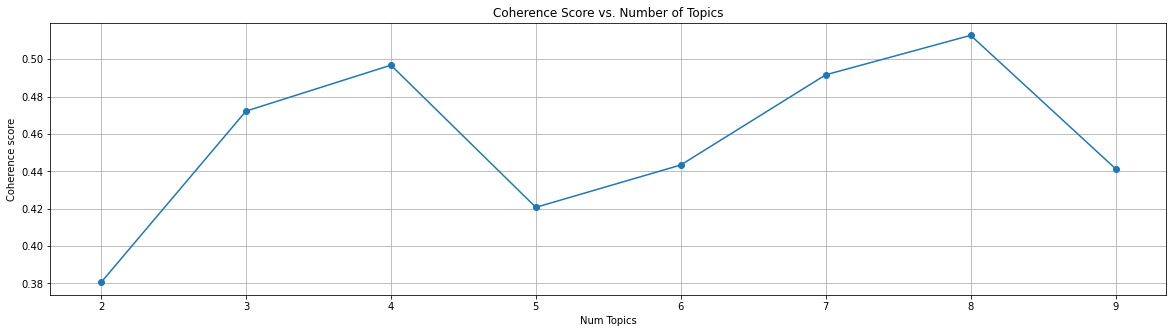

In [ ]:
start=2; limit=10;  step=1;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

### Select the "best" model as the one with the highest Topic Coherence Score

Due to the probabilistic nature of this model, the modeling results can and usually do vary. Despite this, we will select 8 as the number of topics even if this particular model run doesn't show 8 as having the highest coherence score. Also, even if it doesn't, we  need to ask ourselves how many topics we actually want for our corpus. 

In [ ]:
lda_trained_model = model_list[3] 

In [ ]:
lda_trained_model

### For each topic discovered by `gensim`, list the top ten words and their probabilities, 

In [ ]:
pprint(lda_trained_model.print_topics())

[(0,
  '0.011*"armenian" + 0.009*"say" + 0.009*"armenians" + 0.008*"people" + '
  '0.006*"turkish" + 0.005*"come" + 0.004*"know" + 0.004*"kill" + '
  '0.004*"azerbaijan" + 0.004*"armenia"'),
 (1,
  '0.010*"space" + 0.005*"use" + 0.005*"launch" + 0.004*"system" + '
  '0.004*"like" + 0.004*"know" + 0.004*"work" + 0.003*"time" + 0.003*"need" + '
  '0.003*"program"'),
 (2,
  '0.007*"jews" + 0.006*"istanbul" + 0.005*"wire" + 0.005*"university" + '
  '0.004*"ground" + 0.004*"new" + 0.004*"jewish" + 0.003*"turkey" + '
  '0.003*"kuwait" + 0.003*"ottoman"'),
 (3,
  '0.031*"email" + 0.006*"muslims" + 0.004*"serbs" + 0.003*"bosnian" + '
  '0.003*"muslim" + 0.003*"bosnia" + 0.002*"year" + 0.002*"printer" + '
  '0.002*"1993" + 0.002*"element"'),
 (4,
  '0.008*"people" + 0.008*"gun" + 0.007*"right" + 0.006*"think" + '
  '0.005*"israel" + 0.005*"know" + 0.005*"like" + 0.004*"time" + 0.004*"state" '
  '+ 0.004*"law"')]


###Visualize the topics in the best model

In [ ]:
# visualize the topics 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_trained_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.126077 -0.043419       1        1  36.436315
1     -0.096384  0.129168       2        1  30.000392
0     -0.055330 -0.142903       3        1  22.538563
2      0.195429 -0.049872       4        1   6.740687
3      0.082362  0.107027       5        1   4.284044, topic_info=            Term         Freq        Total Category  logprob  loglift
228        email  1054.000000  1054.000000  Default  30.0000  30.0000
824     armenian   953.000000   953.000000  Default  29.0000  29.0000
199        space  1247.000000  1247.000000  Default  28.0000  28.0000
825    armenians   778.000000   778.000000  Default  27.0000  27.0000
616          gun  1137.000000  1137.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
272      article    21.636563   340.215458   Topic5  -6.6278   0.3951
788          say    22.368805  1474.783577   Topic5  -6.5946  -1.0383
1426  university    21.551782   355.952902   Topic5  -6.6318   0.3459
236         good    21.674498   819.965431   Topic5  -6.6261  -0.4829
520        world    21.606277   482.754656   Topic5  -6.6292   0.0437

[402 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
4698       5  0.905918         +61
29614      3  0.982669     -gayane
212        5  0.925721      -tommy
29615      3  0.973825    -zinaida
29743      4  0.943974         0/0
...      ...       ...         ...
3658       3  0.061032  yugoslavia
3658       4  0.030516  yugoslavia
3658       5  0.823934  yugoslavia
2550       1  0.985976     zionism
4742       5  0.894605         |_|

[990 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 4])

## Create a Topic Id --> Topic Name dictionary 


*****This is the "human intervention" step*****:<br>
Edit `vis_topic_name_dict` with YOUR OWN names that YOU assign to the topics that `gensim` discovered.

When populating your Topic Id --> Topic Name dictionary, use the index ordering as shown in the `pyLDAvis` tool. 

In [ ]:
# keys - use topic ids from pyLDAvis visualization 
# values - topic names that you create 
# save dictionary to `vis_topic_name_dict`
###BEGIN SOLUTION
# this is the results from a model run however these topic names might not make sense in future model runs
# thus these names will likely have to be thought through during each lecture 
vis_topic_name_dict = {1:"space program", 
                       2:"guns 'n crime", 
                       3:"mideast-politics-israel-religion", 
                       4:"armenian-turkish-politics", 
                       5:"electical power"}
###END SOLUTION

In [ ]:
df.head()

,content,target,target_names,clean_data,lemmas,filtered_lemmas
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns,[...]\n\nsome of the davidians *are* black.\n\...,"[davidians, black, question]","[davidians, black, question]"
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns,"how about ""firearm related.""\n\n\n texas is un...","[firearm, relate, texas, unusual, regard, nice...","[firearm, relate, texas, unusual, regard, nice..."
2,==========================\n ...,1,sci.space,==========================\n ozone gif images\...,"[ozone, gif, image, april, 1993, gif, image, o...","[ozone, gif, image, april, 1993, gif, image, o..."
3,"From: ""Phil G. Fraering"" <pgf@srl03.cacs.usl.e...",1,sci.space,"from: ""phil g. fraering"" email\n >> finally: t...","[phil, fraering, email, finally, bronze, age, ...","[phil, fraering, email, finally, bronze, age, ..."
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns,from article email email r. stone):\n\ni secon...,"[article, email, email, stone, second, motion,...","[article, email, email, stone, second, motion,..."


## Create a Topic Id lookup dictionary
We'll use a function to map the `pyLDAvis` index ordering to the ordering used in gensim's trained LDA model. 

In [ ]:
model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()
model_vis_tool_topic_id_lookup

{0: 3, 1: 2, 2: 4, 3: 5, 4: 1}

In [ ]:
topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
topic_id_lookup

{1: 4, 2: 1, 3: 0, 4: 2, 5: 3}

In [ ]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic ids bewteen the trained LDA model 
    and the viz tool are different. So we need to create a look up dictionary that maps 
    the correct association between topic ids from both sources. 
    """
    # value is order of topic ids according to pyLDAvis tool 
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # invert dictionary so that 
    # key is order of topic ids accoridng to pyLDAvis tool 
    # value is order of topic ids according to the trained lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
    
    # iterate through topic_id_lookup and index vis_topic_name_dict using the keys 
    # in order to swap the viz topic ids in vis_topic_name_dict for the lda model topic ids 
    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

In [ ]:
###BEGIN SOLUTION
# now we have an updated topic id/name dict
# the topic ids correspond to how the lda model has indexed the topics 
# now we can use this dictionary with lda model to label our docs 
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)
###END SOLTUION

In [ ]:
topic_name_dict

{0: 'mideast-politics-israel-religion',
 1: "guns 'n crime",
 2: 'armenian-turkish-politics',
 3: 'electical power',
 4: 'space program'}

## Use the LDA Model to Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name. 

This function iterates over the documents in a corpus and outputs a list with the topic ID -- according to the trained `lda_model` -- of the highest-probability topic for each document

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output. 

In [ ]:
def get_topic_ids_for_docs(lda_model, corpus):
    
    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document. 
    
    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model 
        
    corpus: nested lists of tuples, 
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]
        
    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus 
    """
    
    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:
        
        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic 
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)
        
        # iterate through the topic id/prob pairs 
        for topic_id_prob in topic_id_prob_tuples:
            
            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get index for largest prob score
        max_topic_prob_ind = np.argmax(topic_probs)
        # get corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store topic id that had the highest prob for doc being a memebr of that topic
        doc_topic_ids.append(max_prob_topic_id)
        
    return doc_topic_ids

In [ ]:
# get the topic id for each doc in the corpus 
topic_id_list = get_topic_ids_for_docs(lda_trained_model, corpus)

# create a feature for document's topic id
df["topic_id"] = topic_id_list

# iterate through the topic id and use the lookup table to assign each document with a topic name
df["new_topic_name"] = df["topic_id"].apply(lambda topic_id: topic_name_dict[topic_id])

In [ ]:
# cool! so now all of our documents have topic ids and names 
df.head()

,content,target,target_names,clean_data,lemmas,filtered_lemmas,topic_id,new_topic_name
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns,[...]\n\nsome of the davidians *are* black.\n\...,"[davidians, black, question]","[davidians, black, question]",4,space program
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns,"how about ""firearm related.""\n\n\n texas is un...","[firearm, relate, texas, unusual, regard, nice...","[firearm, relate, texas, unusual, regard, nice...",4,space program
2,==========================\n ...,1,sci.space,==========================\n ozone gif images\...,"[ozone, gif, image, april, 1993, gif, image, o...","[ozone, gif, image, april, 1993, gif, image, o...",1,guns 'n crime
3,"From: ""Phil G. Fraering"" <pgf@srl03.cacs.usl.e...",1,sci.space,"from: ""phil g. fraering"" email\n >> finally: t...","[phil, fraering, email, finally, bronze, age, ...","[phil, fraering, email, finally, bronze, age, ...",3,electical power
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns,from article email email r. stone):\n\ni secon...,"[article, email, email, stone, second, motion,...","[article, email, email, stone, second, motion,...",4,space program


Using a boolean filter, or mask, you can slice out all articles of a certain topic, i.e. topic_id 3

In [ ]:
science_mask = df.topic_id == 4
science_df = df[science_mask]

science_df.head(-5)

,content,target,target_names,clean_data,lemmas,filtered_lemmas,topic_id,new_topic_name
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns,[...]\n\nsome of the davidians *are* black.\n\...,"[davidians, black, question]","[davidians, black, question]",4,space program
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns,"how about ""firearm related.""\n\n\n texas is un...","[firearm, relate, texas, unusual, regard, nice...","[firearm, relate, texas, unusual, regard, nice...",4,space program
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns,from article email email r. stone):\n\ni secon...,"[article, email, email, stone, second, motion,...","[article, email, email, stone, second, motion,...",4,space program
6,"\n Even better, let's pass a law making it il...",2,talk.politics.guns,"even better, let's pass a law making it illega...","[better, let, pass, law, make, illegal, kill, ...","[better, let, pass, law, make, illegal, kill, ...",4,space program
7,\nI have always thought that if I wanted to se...,0,sci.electronics,i have always thought that if i wanted to send...,"[think, want, send, police, tape, ransom, dema...","[think, want, send, police, tape, ransom, dema...",4,space program
...,...,...,...,...,...,...,...,...
3799,A friend recorded CNN news during the gassing ...,2,talk.politics.guns,a friend recorded cnn news during the gassing ...,"[friend, record, cnn, news, gassing, incinerat...","[friend, record, cnn, news, gassing, incinerat...",4,space program
3803,"Editorial - A10, Saturday, April 24, 1993\n\n ...",2,talk.politics.guns,"editorial - a10, saturday, april 24, 1993\n\n ...","[editorial, a10, saturday, april, 1993, crimes...","[editorial, a10, saturday, april, 1993, crimes...",4,space program
3805,\n\nBut this is all gun control laws end up do...,2,talk.politics.guns,but this is all gun control laws end up doing....,"[gun, control, law, end, politician, manage, h...","[gun, control, law, end, politician, manage, h...",4,space program
3806,In my first posting on this subject I threw ou...,1,sci.space,in my first posting on this subject i threw ou...,"[posting, subject, throw, idea, fund, contest,...","[posting, subject, throw, idea, fund, contest,...",4,space program


In [ ]:
print(science_df['lemmas'][3806])

['posting', 'subject', 'throw', 'idea', 'fund', 'contest', 'delve', 'deep', 'budget', 'mention', 'grant', 'mineral', 'right', 'winner', 'actual', 'wording', 'mine', 'right', 'somebody', 'point', 'correctly', 'right', 'anybody', 'grant', 'imagine', 'fait', 'accompli', 'situation', 'winner', 'win', 'group', 'company', 'corp', 'year', 'moratorium', 'taxis']


-----

## Knowledge is Power! What Can We Do with the Knowledge We Just Gained?

Outside of this guided project (i.e. in your job) you may or may not have access to existing article topic names like we did with this data set. Meaning that you won't always have a point of reference to "check your answers". So let's explore two possible situations in which you might find yourself using Latent Dirichlet Allocation (LDA) Topic Modeling. 

### 1. You have access to existing document topic labels

In this case, why would you bother with Topic Modeling? It could be the case that the current topic labels are actually not helpful for whatever task you're working on. For instance, in this guided project, our email dataset has topic names; however those topic labels are hierarchical, which may not suit your needs. So one option is generate new labels that do suit your needs (as we did here). 

### 2. Your corpus doesn't have any document topic labels

In this case, you don't have any pre-existing topic labels. Maybe you work at Indeed or LinkedIn or Google and your job is to bring some structure to a huge collection of emails and messages that aren't labeled in any meaningful way and so it's difficult to just sort through these documents. This is a perfect use case of Topic Modeling. After you apply topic modeling, you'll then have organized your emails into broad categories and you can start structuring and then analyze your corpus, and maybe even build a supervised learning model to predict the topic of the document!

## Topic Modeling References


- [Topic Modeling with Gensim](https://www.tutorialspoint.com/gensim/gensim_topic_modeling.htm) -- Brief Tutorial

- [Gensim documentation](https://radimrehurek.com/gensim/index.html) -- look up gensim commands

- [`pyLDAvis` documentation](https://pyldavis.readthedocs.io/en/latest/readme.html) -- package for visualizing LDA models

- [Visualizing Topic Models](https://speakerdeck.com/bmabey/visualizing-topic-models) -- slides from Ben Mabey

- [Exploring the Space of Topic Coherence Measures](https://dl.acm.org/doi/10.1145/2684822.2685324) -- Study of Topic Coherence measures

- [Exploring Topic Coherence over many models and many topics](https://www.researchgate.net/publication/232242203_Exploring_Topic_Coherence_over_many_models_and_many_topics) -- Study of automated topic coherence measures